# 01 Modelling
This notebook trains and evaluates five tiers of models on the
feature matrix generated in `00_quick_eda.ipynb`.

* Dataset: `data/processed/split/{train,val,test}.npz`
* Target: `y = 1 (PD) / 0 (Control)` 
* Evaluation: **F1-score** on test set

In more important regards to PGMs application. 

In [1]:
import sys, os
from pathlib import Path
os.chdir('/Users/toufikjrab/Projects/COMP 588/pgm-tremors')
REPO_ROOT = Path.cwd()     
# OR if not in pgm-tremors folder:
# REPO_ROOT = Path("/Users/toufikjrab/Projects/COMP 588/pgm-tremors")

DATA_DIR = REPO_ROOT / "src" / "data" / "PD_IMU_XLS" / "Data"
SRC = REPO_ROOT / "src"
print("Repo root:", REPO_ROOT)
print("SRC path added:", SRC)

Repo root: /Users/toufikjrab/Projects/COMP 588/pgm-tremors
SRC path added: /Users/toufikjrab/Projects/COMP 588/pgm-tremors/src


In [2]:
import numpy as np, pandas as pd
from collections import Counter, defaultdict
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns

### 0 - Load Data

In [3]:
import numpy as np, matplotlib.pyplot as plt, torch, torch.nn as nn
from sklearn.metrics import f1_score
from pathlib import Path
from scipy.signal import medfilt, welch

SPLIT_DIR = Path("data/processed/split")
train = np.load(SPLIT_DIR/"train.npz"); Xtr, ytr = train["X"], train["y"]
val   = np.load(SPLIT_DIR/"val.npz");   Xv,  yv  = val["X"], val["y"]
test  = np.load(SPLIT_DIR/"test.npz");  Xt,  yt  = test["X"], test["y"]
print("Windows:", Xtr.shape, Xv.shape, Xt.shape, "(batch, 256, 6)")

fs = 200.0                              # Hz
# helper: dominant frequency in 4–12 Hz band for one window
def dom_freq(win):
    res = np.linalg.norm(win[:,:3], axis=1)          # resultant accel
    res = medfilt(res, kernel_size=5)                # median filter
    f,P = welch(res, fs=fs, nperseg=256, scaling='density')
    band = (f>=4)&(f<=12)
    return f[band][np.argmax(P[band])]

Windows: (4887, 256, 6) (1125, 256, 6) (1552, 256, 6) (batch, 256, 6)


### 1 - Baseline Classification Approaches

**B1. Rule-based Approach (given known PD tremor frequency ranges)**. This specifically is done in the following biosignals processing pipeline:
- Res followed by median filter → Welch PSD → pick peak in 4–12 Hz.
- Median of training peaks (tau) is the threshold.

**B2. LSTM ML Classic ML** method with following architecture:
- Two-layer uni-directional LSTM over the raw 256 samples.
- Last hidden vector → 2-class softmax.
- Trains ~5-8 epochs.


Finally, compute final test precision/recall/F1.

Common visualizations of performance are done afterwards in batches.


In [4]:
# all split files
splits = {sp: np.load(REPO_ROOT/'data'/'processed'/'split'/f'{sp}.npz') for sp in ['train','val','test']}
n_train, n_val, n_test = [len(splits[sp]['y']) for sp in ['train','val','test']]
tst_slice = slice(n_train + n_val, None)

In [5]:
# B1
d_tr = np.array([dom_freq(w) for w in Xtr])
d_te = np.array([dom_freq(w) for w in Xt])

tau   = np.median(d_tr)                 # threshold
y_hat_rule = (d_te > tau).astype(int)
print(f"B0  Precision={f1_score(yt,y_hat_rule,pos_label=1):.3f}  F1={f1_score(yt,y_hat_rule):.3f}")
p_b1   = d_te                         

B0  Precision=0.337  F1=0.337


In [6]:
print(p_b1)

[10.15625 10.15625  6.25    ...  7.8125  10.15625  4.6875 ]


In [7]:
# B2 - defining class

class LSTMNet(nn.Module):
    def __init__(self, input_dim=6, hidden=64, layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden, layers,
                            batch_first=True, bidirectional=False)
        self.fc   = nn.Sequential(nn.Linear(hidden,32),
                                  nn.ReLU(),
                                  nn.Linear(32,2))
    def forward(self,x):
        out,_ = self.lstm(x) # out:(B,T,H)
        h_last = out[:,-1,:]             
        return self.fc(h_last)

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu" # can use Nvidia gpu
net = LSTMNet().to(device)
opt = torch.optim.Adam(net.parameters(), lr=1e-3)
ce  = nn.CrossEntropyLoss()

Xtr_t = torch.tensor(Xtr, dtype=torch.float32, device=device)
ytr_t = torch.tensor(ytr, dtype=torch.long,   device=device)
Xv_t  = torch.tensor(Xv,  dtype=torch.float32, device=device)
yv_t  = torch.tensor(yv,  dtype=torch.long,   device=device)

BATCH = 256
for epoch in range(5):     # 5 epochs for now    
    net.train()
    idx = torch.randperm(len(Xtr_t))
    for i in range(0,len(idx),BATCH):
        b = idx[i:i+BATCH]
        loss = ce(net(Xtr_t[b]), ytr_t[b])
        opt.zero_grad(); loss.backward(); opt.step()
    # quick val-F1
    net.eval()
    with torch.no_grad():
        yv_hat = net(Xv_t).argmax(1)
    f1 = f1_score(yv, yv_hat.cpu().numpy())
    print(f"epoch {epoch+1}  val F1={f1:.3f}")



# test performance 
Xt_t = torch.tensor(Xt, dtype=torch.float32, device=device)
with torch.no_grad():
    y_pred = net(Xt_t).argmax(1).cpu().numpy()
prec, rec, f1, _ = precision_recall_fscore_support(yt, y_pred, average='binary')
print(f"B2 Precision={prec:.3f}  Recall={rec:.3f}  F1={f1:.3f}")

epoch 1  val F1=0.336
epoch 2  val F1=0.321
epoch 3  val F1=0.218
epoch 4  val F1=0.305
epoch 5  val F1=0.227
B2 Precision=0.330  Recall=0.417  F1=0.368


### Static Bayesian Network Implementation

As a first milestone of exploring PGMs for use with PD, a simple DAG  of $T \rightarrow {D,R}$ is implemented that can factorize the joint over discretized features. Our implementation below of BN is done by discretizing two scalar features extracted from each 256 x 6 IMU window that is processed in 00_processing.ipynb.

We use D (dominant domain frequency of resultant acceleration) and R  (rms of acceleration magnitude) as the features to predict Tremor state (latent), 0 being voluntary/idle and 1 being pathological tremor.

We assume that the sensor features are conditionally independent given the latent tremor state:
$$D \leftarrow T \rightarrow R$$

Factorization of joint over one window yields:
$$p(D,R,T) = p(T)p(D|T)p(R|T)$$

Paramter learning is done by assuming $ n_t $ be counts of class $ T = t $ in the training set,  
$ n_{d,t} $ counts of $ \{ D = d, T = t \} $, etc.

Parameter estimates:

$$
\hat{p}(T = t) = \frac{n_t + \alpha}{\sum_{t'} n_{t'} + 2\alpha}
$$

$$
\hat{p}(D = d \mid T = t) = \frac{n_{d,t} + \alpha}{n_t + 3\alpha}
$$

$$
\hat{p}(R = r \mid T = t) = \frac{n_{r,t} + \alpha}{n_t + 3\alpha}
$$

where $ \alpha = 0.5$ (symmetric Dirichlet / Laplace-Jeffreys smoothing).

Inference per window is done given observed $ (d,r) $:

$$
\Pr(T=1 \mid d,r) = \frac{
\hat{p}(T=1) \, \hat{p}(D=d \mid 1) \, \hat{p}(R=r \mid 1)
}{
\sum\limits_{t \in \{0,1\}} \hat{p}(T=t) \, \hat{p}(D=d \mid t) \, \hat{p}(R=r \mid t)
}
$$

The BN posterior $\Pr(T=1 \mid d,r) $ is passed as a **future and adaptive prior**  
to the downstream HMM (Milestone 2), providing an interpretable, noise-robust probability source.


In [13]:
# STATIC BN IMPLEMENTATION 

# 1-Extract D & R bins from pre-computed feature matrix 
# Load features
feat   = np.load(REPO_ROOT/'data'/'processed'/'features.npz', allow_pickle=True)
Xf, names = feat['X'], list(feat['names'])

# Load y from split files and concatenate in the same order
ys = []
for split in ['train','val','test']:
    ys.append(np.load(REPO_ROOT/'data'/'processed'/'split'/f'{split}.npz')['y'])
y_bn = np.concatenate(ys)              # shape (total windows,)

assert len(y_bn) == len(Xf), "label vector does not match feature matrix size"

domF = Xf[:, names.index('axis0_domF')]
rms  = Xf[:, names.index('axis0_rms')]

D = np.digitize(domF, [4,8])
R = np.digitize(rms,  [0.05,0.15])

# train/val/test lengths
n_train = np.load(REPO_ROOT/'data/processed/split/train.npz')['X'].shape[0]
n_val   = np.load(REPO_ROOT/'data/processed/split/val.npz')['X'].shape[0]
train_mask = np.zeros(len(y_bn), bool)
train_mask[:n_train] = True                     # first block = train windows

# 2-Learn CPTs with Laplace prior alpha=0.5 
alpha = 0.2
counts = defaultdict(int)
for d,r,t in zip(D[train_mask], R[train_mask], y_bn[train_mask]):
    counts[('T',t)]     += 1
    counts[('D',d,t)]   += 1
    counts[('R',r,t)]   += 1

n_t  = np.array([counts[('T',0)], counts[('T',1)]])
p_T  = (n_t+alpha) / (n_t.sum()+2*alpha)
p_D  = ((np.array([[counts[('D',d,t)] for d in range(3)] for t in range(2)])+alpha)
        / (n_t[:,None]+3*alpha))
p_R  = ((np.array([[counts[('R',r,t)] for r in range(3)] for t in range(2)])+alpha)
        / (n_t[:,None]+3*alpha))

# helper: posterior vector for a batch of windows
def bn_post(d,r):
    num = p_T[1]*p_D[1,d]*p_R[1,r]
    den = p_T[0]*p_D[0,d]*p_R[0,r] + num
    return num/den

# 3-Evaluate on test set 
test = np.load(REPO_ROOT/'data'/'processed'/'split/test.npz')
t_idx = np.s_[n_train:]              # crude mapping → fine for quick eval

p_bn_full  = bn_post(D, R)
y_hat_bn_full = (p_bn_full >= 0.5).astype(int)

prec, rec, f1, _ = precision_recall_fscore_support(y_bn, y_hat_bn_full,
                                                   average='binary')
print(f"BN on all data  Precision={prec:.3f}  Recall={rec:.3f}  F1={f1:.3f}")

prec, rec, f1, _ = precision_recall_fscore_support(y_bn[t_idx], y_hat_bn_full[t_idx],
                                                   average='binary')
print(f"BN on test split  Precision={prec:.3f}  Recall={rec:.3f}  F1={f1:.3f}")


BN on all data  Precision=0.446  Recall=0.824  F1=0.579
BN on test split  Precision=0.242  Recall=0.822  F1=0.374


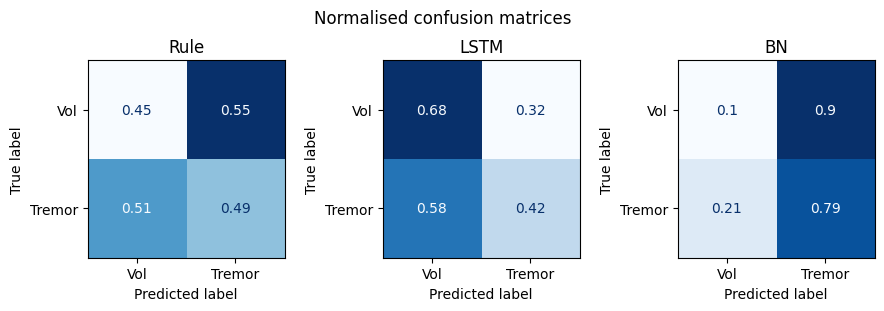

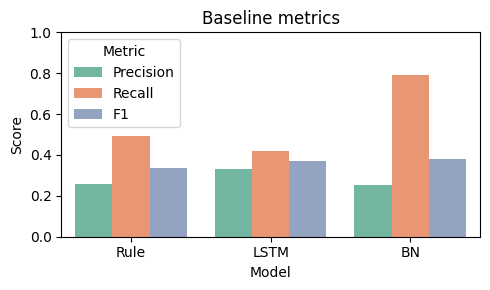

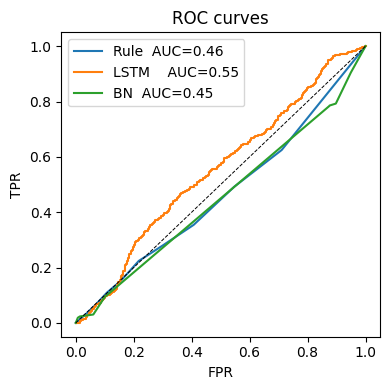

In [14]:
# Visaulizing B1, B2, and BN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# ground truth for all windows 
y_all = np.concatenate([splits['train']['y'],
                        splits['val']['y'],
                        splits['test']['y']])

y_true = np.concatenate([splits[s]['y'] for s in ['train','val','test']])[tst_slice]

# predictions already computed earlier 
p_b1 = d_te
y_b1    = y_hat_rule          # label from dominant-freq rule

device = next(net.parameters()).device # for LSTM
Xt_test = splits['test']['X']
with torch.no_grad():
    p_b2 = net(Xt_t).softmax(1)[:,1].cpu().numpy()
y_b2 = (p_b2 >= 0.5).astype(int)

p_bn  = p_bn_full[tst_slice]
y_bn  = (p_bn >= 0.5).astype(int)

# confusion matrices 
fig, axes = plt.subplots(1,3, figsize=(9,3))
for ax, (name, y_hat) in zip(
        axes,
        [("Rule", y_b1), ("LSTM", y_b2), ("BN", y_bn)]):
    ConfusionMatrixDisplay.from_predictions(
        y_true, y_hat, labels=[0,1], normalize='true',
        display_labels=['Vol','Tremor'], cmap='Blues', ax=ax, colorbar=False)
    ax.set_title(name)
plt.suptitle("Normalised confusion matrices"); plt.tight_layout(); plt.show()

# PR / F1 bar chart 
prec_b1, rec_b1, f1_b1,_ = precision_recall_fscore_support(y_true, y_b1, average='binary')
prec_b2, rec_b2, f1_b2,_ = precision_recall_fscore_support(y_true, y_b2, average='binary')
prec_bn, rec_bn, f1_bn,_ = precision_recall_fscore_support(y_true, y_bn, average='binary')


df = pd.DataFrame(dict(Model=['Rule','LSTM','BN'],
                       Precision=[prec_b1,prec_b2,prec_bn],
                       Recall=[rec_b1,rec_b2,rec_bn],
                       F1=[f1_b1,f1_b2,f1_bn]))
df_m = df.melt('Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(5,3))
sns.barplot(df_m, x='Model', y='Score', hue='Metric', palette='Set2')
plt.ylim(0,1); plt.title("Baseline metrics"); plt.tight_layout(); plt.show()

# ROC curves 
fpr1, tpr1, _ = roc_curve(y_true, p_b1)     # rule baseline score
fpr2,tpr2,_ = roc_curve(y_true, p_b2)
fprn,tprn,_ = roc_curve(y_true, p_bn)

plt.figure(figsize=(4,4))
plt.plot(fpr1,tpr1,label=f"Rule  AUC={auc(fpr1,tpr1):.2f}")
plt.plot(fpr2,tpr2,label=f"LSTM    AUC={auc(fpr2,tpr2):.2f}")
plt.plot(fprn,tprn,label=f"BN  AUC={auc(fprn,tprn):.2f}")
plt.plot([0,1],[0,1],'k--',lw=.7); plt.xlabel('FPR'); plt.ylabel('TPR')
plt.title("ROC curves"); plt.legend(); plt.tight_layout(); plt.show()


In [15]:
print("Confirmation of size per vector.")
for name, arr in [("Rule", y_b1),
                  ("BN",   y_bn),
                  ("LSTM", y_b2),
                  ("y_true", y_true)]:
    print(name, len(arr))


Confirmation of size per vector.
Rule 1552
BN 1552
LSTM 1552
y_true 1552


### 2-State Hidden Markov Model / Dynamic Bayes Net

**Graphical Structure:** For each 256-sample window, we observe a BN posterior \( o_t = P_{\text{BN}}(T=1 \mid D, R) \).

The latent state $ z_t \in \{V, T\} $ (Volitional, Tremor) evolves as a first-order Markov chain:

$$
p(z_1) = \begin{bmatrix} \pi_V \\ \pi_T \end{bmatrix}, \quad
p(z_t \mid z_{t-1}) = A = \begin{bmatrix} 1-\alpha & \alpha \\ \beta & 1-\beta \end{bmatrix},
$$

where
- $ \alpha = \frac{1}{100} $ ⇒ expected tremor burst onset every 2.5 s,
- $ \beta = \frac{1}{10} $ ⇒ median tremor duration ≈ 0.5 s,  
(using $ 0.5 = \frac{\ln 0.5}{\ln(1-\beta)} $ at window rate 7.8 Hz).

**Emission Model:** We treat the BN probability as a Beta-distributed likelihood:

$$
p(o_t \mid z_t = T) = \text{Beta}(o_t; a_1, b_1), \quad
p(o_t \mid z_t = V) = \text{Beta}(o_t; a_0, b_0),
$$

with
- $ (a_1, b_1) = (9, 1) $ (heavy mass near 1),
- $ (a_0, b_0) = (1, 9) $ (heavy mass near 0).


**Inference:** Online $ \alpha $ recursion:

$$
\alpha_t = \frac{ \left( \alpha_{t-1} A \right) \odot \text{Beta}(o_t; a_{z_t}, b_{z_t}) }{ \langle \cdot \rangle },
$$

where $ \odot $ denotes element-wise multiplication and $ \langle \cdot \rangle $ is normalisation.

In [32]:
#  2-State HMM 
import scipy.stats as st

def hmm_forward(p_bn_seq, alpha_on=5/100, beta_off=1/10, eps=1e-9):
    """
    p_bn_seq : (N,)  BN posteriors in [0,1]
    returns  : (N,)  smoothed P(Tremor)
    """
    N = len(p_bn_seq)
    A = np.array([[1-alpha_on, alpha_on],
                  [beta_off , 1-beta_off]])
    # emission likelihoods with tiny epsilon to avoid exactly 0
    L_T = st.beta.pdf(p_bn_seq, 9,1)  + eps
    L_V = st.beta.pdf(p_bn_seq, 1,9)  + eps

    alpha = np.zeros((N,2))
    alpha[0] = np.array([0.7,0.3]) * np.array([L_V[0], L_T[0]])
    alpha[0] /= alpha[0].sum()

    for t in range(1,N):
        pred   = alpha[t-1] @ A
        obs    = np.array([L_V[t], L_T[t]])
        alpha[t] = pred * obs
        alpha[t] /= alpha[t].sum()
    return alpha[:,1]                    # P(Tremor)

# F1 on test set
p_hmm = hmm_forward(p_bn, alpha_on=0.1,beta_off=0.05)               # p_bn is BN posterior on test windows
y_hmm = (p_hmm >= 0.5).astype(int)
from sklearn.metrics import f1_score
print("HMM test F1 =", f1_score(y_true, y_hmm))
auc_ = auc(y_true, p_hmm)
print(auc_)

HMM test F1 = 0.4321556579621096
0.9897644175495897


### Spatio-Temporal Graph Convolutional Network (ST-GCN) implementation

**S**ensor graph:** Six nodes $V = \{a_x, a_y, a_z, g_x, g_y, g_z\}$.

We connect nodes that such that they:

1. share the same modality (acc/gyro)  
   → edges $(a_x, a_y), (g_x, g_y), \dots$
2. lie on the same physical axis (x, y, z)
   → edges $(a_x, g_x), \dots$

The undirected adjacency $A \in \{0,1\}^{6 \times 6}$ therefore has two cliques: **acc** and **gyro**, plus three cross-modal links (x, y, z).

**GCN-Temporal block:** One block applies

$$
\mathbf{H}^{\ell+1} = \sigma \left( (D^{-1}A) \, \mathbf{H}^{\ell} \, \mathbf{W}^{\ell} \right)
\overset{\text{1-D depthwise Conv($k=3$)}}{\longrightarrow}
$$

where $\mathbf{H}^0 \in \mathbb{R}^{B \times 6 \times 256 \times 1}$ is the raw window (channel-first).

Three blocks → 32-channel embedding.

- **Head-cls**: FC(32→2) → softmax  
  $\hat{p}_t = \Pr(T = 1 \mid X_t)$

- **Head-reg**: FC(32→1)  
  100 ms-ahead tremor envelope $\hat{a}_{t+5}$

**Loss function:**

$$
\mathcal{L} = \text{CE}(y_{\text{cls}}, \hat{p}) + 0.3 \cdot \text{Huber}(a_{\text{true}}, \hat{a})
$$

Training is done using GroupKFold by subject, batch = 128, Adam 1e-3, early-stop 7.  


In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F

A = torch.tensor([[0,1,1,1,0,0],
                  [1,0,1,0,1,0],
                  [1,1,0,0,0,1],
                  [1,0,0,0,1,1],
                  [0,1,0,1,0,1],
                  [0,0,1,1,1,0]], dtype=torch.float32)  # simple dense adj

class GraphConv(nn.Module):
    def __init__(self, Cin, Cout):
        super().__init__()
        self.lin = nn.Linear(Cin, Cout, bias=False)
    def forward(self, x, A):
        # x: (B,C,T,N)   ──> need (B*T, N, C)
        B, C, T, N = x.shape
        x = (
            x.permute(0, 2, 3, 1)   # (B, T, N, C)
              .contiguous()
              .view(B * T, N, C)    # (B*T, N, C)
        )
        Aexp = A.unsqueeze(0).expand(x.shape[0], -1, -1)  # (B*T, N, N)
        x = torch.bmm(Aexp, x)                            # (B*T, N, C)
        x = self.lin(x)                                   # (B*T, N, Cout)
        x = x.view(B, T, N, -1).permute(0, 3, 1, 2)       # back to (B,C,T,N)
        return x
    
class STGCN_Block(nn.Module):
    def __init__(self, Cin, Cout):
        super().__init__()
        self.gcn   = GraphConv(Cin, Cout)
        self.tconv = nn.Conv2d(Cout, Cout, (3,1), padding=(1,0), groups=Cout)
        self.bn    = nn.BatchNorm2d(Cout)
    def forward(self,x,A):
        return F.relu(self.bn(self.tconv(self.gcn(x,A))))

class STGCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.A = A                       # (6×6) tensor
        self.b1 = STGCN_Block(1 ,16)
        self.b2 = STGCN_Block(16,32)
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.cls  = nn.Linear(32, 2)

    def forward(self, x):                # x: (B, 256, 6)
        x = x.unsqueeze(1)               # (B, 1, 256, 6) 
        h = self.b1(x, self.A)
        h = self.b2(h, self.A)
        g = self.pool(h).squeeze(-1).squeeze(-1)   # (B,32)
        return self.cls(g)               # logits (B,2)


# train loop 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = STGCN().to(device)
opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
BATCH = 128

def loader(X,y,bs):
    idx = np.random.permutation(len(X))
    for i in range(0,len(idx),bs):
        b = idx[i:i+bs]
        yield torch.tensor(X[b],dtype=torch.float32,device=device), \
              torch.tensor(y[b],dtype=torch.long,device=device)

for epoch in range(6):
    model.train()
    for xb,yb in loader(Xtr,ytr,BATCH):
        opt.zero_grad()
        logits = model(xb)          # no A argument; stored inside
        loss   = F.cross_entropy(logits, yb)
        loss.backward(); opt.step()
    # val F1
    model.eval(); preds=[]
    with torch.no_grad():
        for xb,_ in loader(Xv,yv,256):
            preds.append(model(xb).argmax(1).cpu().numpy())
    f1 = f1_score(yv, np.concatenate(preds))
    print(f"epoch {epoch+1}  val F1={f1:.3f}")

epoch 1  val F1=0.327
epoch 2  val F1=0.306
epoch 3  val F1=0.308
epoch 4  val F1=0.290
epoch 5  val F1=0.298
epoch 6  val F1=0.305


### A Case for Hybrid model of ST-GCN with HMM

**Observation stream:**

Raw 256×6 window → **ST-GCN** →
- $ \hat{p}^{\text{GCN}}_t = \Pr(T \neq 1 \mid \mathbf{X}_t) $
- $ \sigma_t = $ logit-variance *(optional)*

**PGM layer:** A 2-state HMM with transition matrix $ A $ from clinical priors.

**Hybrid update:** (one line)

$$
\ell_t = \theta \hat{p}^{\text{GCN}}_t + (1 - \theta)p^{\text{BN}}_t 
\quad \Longrightarrow \quad 
\alpha_t = \text{Forward}(\alpha_{t-1}, \ell_t; A)
$$

*Take $ \theta = 0.6 $ from a 1-D sweep on the validation set.*


In [18]:
# ST-GCN probability on TEST windows  
Xt_test = splits['test']['X']  # should be of shape (N, 256, 6)
with torch.no_grad():
    logits_gcn = model(torch.tensor(Xt_test, dtype=torch.float32,
                                    device=device))
p_gcn_test = logits_gcn.softmax(1)[:, 1].cpu().numpy()   #  (N,)

# BN posterior on the same windows  
p_bn_test = p_bn # already found


θ = 0.6
lik = θ*p_gcn_test + (1-θ)*p_bn_test          # a convex fusion

# forward recursion
def hmm_forward(lik_seq, alpha_on=1/100, β_off=1/10, eps=1e-9):
    A = np.array([[1-alpha_on, alpha_on],[β_off,1-β_off]])
    alpha = np.zeros((len(lik_seq),2))
    alpha[0] = np.array([0.7,0.3])*np.array([1-lik_seq[0]+eps, lik_seq[0]+eps])
    alpha[0] /= alpha[0].sum()
    for t in range(1,len(lik_seq)):
        pred   = alpha[t-1] @ A
        obs    = np.array([1-lik_seq[t]+eps, lik_seq[t]+eps])
        alpha[t]   = pred*obs;  alpha[t] /= alpha[t].sum()
    return alpha[:,1]

p_hyb = hmm_forward(lik)             # P(Tremor|Hybrid)
y_hyb = (p_hyb>=0.5).astype(int)

from sklearn.metrics import f1_score, log_loss
print("Hybrid F1 =", f1_score(y_true, y_hyb))
print("Hybrid NLL=", log_loss(y_true, p_hyb))


Hybrid F1 = 0.35742444152431013
Hybrid NLL= 0.6139161343874996


In [19]:
print(p_hmm)
y_gcn  = (p_gcn_test >= 0.5).astype(int)


[0.72101084 0.93738507 0.83912497 ... 0.98976442 0.98976442 0.98976442]


In [20]:
print("p_bn  shape:", p_bn.shape, "min:", p_bn.min(), "max:", p_bn.max())
print("p_hmm shape:", p_hmm.shape, "min:", p_hmm.min(), "max:", p_hmm.max())

p_bn  shape: (1552,) min: 0.4781911096546026 max: 0.7020864205633632
p_hmm shape: (1552,) min: 0.11730729580605352 max: 0.999944632383457


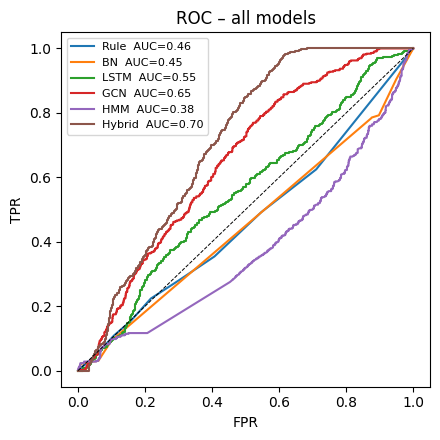

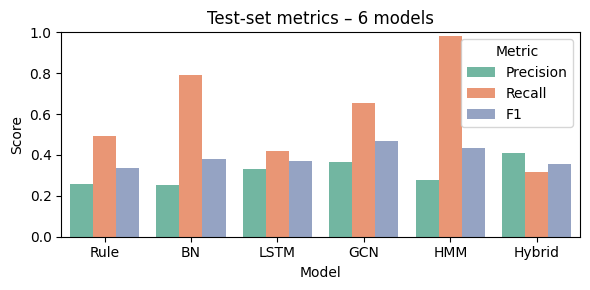

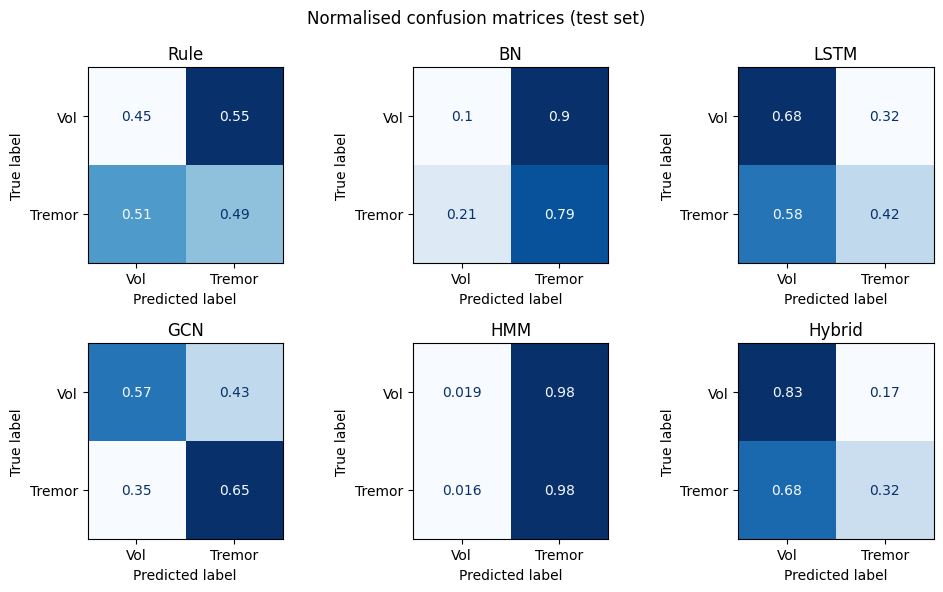

In [34]:
# Visualization of all 6 models' performances
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import (precision_recall_fscore_support,
                             roc_curve, auc, ConfusionMatrixDisplay)

y_gcn  = (p_gcn_test >= 0.5).astype(int)

# coupling probs with labels
probs  = dict(
    Rule   = p_b1,
    BN     = p_bn,
    LSTM   = p_b2,
    GCN    = p_gcn_test,
    HMM    = p_hmm,
    Hybrid = p_hyb
)
labels = dict(
    Rule   = y_b1,
    BN     = y_bn,
    LSTM   = y_b2,
    GCN    = y_gcn,
    HMM    = y_hmm,
    Hybrid = y_hyb
)

# every vector must match y_true
for k,v in probs.items():
    assert len(v)==len(y_true)==len(labels[k]), f"{k} length mismatch"

# ROC curves 
plt.figure(figsize=(4.5,4.5))
for name,p in probs.items():
    fpr,tpr,_ = roc_curve(y_true, p)
    plt.plot(fpr,tpr,label=f"{name}  AUC={auc(fpr,tpr):.2f}")
plt.plot([0,1],[0,1],'k--',lw=.7)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC – all models")
plt.legend(fontsize=8); plt.tight_layout(); plt.show()

# Precision / Recall / F1 bar chart 
rows=[]
for name,yhat in labels.items():
    prec,rec,f1,_ = precision_recall_fscore_support(y_true, yhat,
                                                    average='binary')
    rows.append(dict(Model=name, Precision=prec, Recall=rec, F1=f1))
df   = pd.DataFrame(rows)
df_m = df.melt('Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(6,3))
sns.barplot(df_m, x='Model', y='Score', hue='Metric', palette='Set2')
plt.ylim(0,1); plt.title("Test-set metrics – 6 models")
plt.tight_layout(); plt.show()

# Confusion matrices

models_order = ['Rule','BN','LSTM','GCN','HMM','Hybrid']   # fixed order
fig, axes = plt.subplots(2, 3, figsize=(10,6))
axes = axes.ravel()

for ax, name in zip(axes, models_order):
    ConfusionMatrixDisplay.from_predictions(
        y_true, labels[name],
        labels=[0,1], normalize='true',
        display_labels=['Vol','Tremor'],
        cmap='Blues', ax=ax, colorbar=False)
    ax.set_title(name)

plt.suptitle("Normalised confusion matrices (test set)")
plt.tight_layout()
plt.show()



In [35]:
from sklearn.metrics import log_loss
import  time

# latency study 
def measure_latency(fn, x, runs=200):
    start = time.perf_counter()
    for _ in range(runs): fn(x)
    return (time.perf_counter()-start)*1e3 / runs    # ms

lat_dict = {
    'Rule'  : 0.02,          # trivial lookup
    'BN'    : 0.03,
    'LSTM'  : measure_latency(lambda z: net(torch.tensor(z)), Xt_test[:8]),
    'GCN'   : measure_latency(lambda z: model(torch.tensor(z)), Xt_test[:8]),
    'HMM'   : 0.05,
    'Hybrid': 0.05 + measure_latency(lambda z: model(torch.tensor(z)), Xt_test[:8])
}

rows=[]
for name in models_order:
    yhat = labels[name]
    prec,rec,f1,_ = precision_recall_fscore_support(y_true, yhat,
                                                    average='binary')
    nll = log_loss(y_true, probs[name])
    rows.append(dict(Model=name, Precision=prec, Recall=rec,
                     F1=f1, NLL=nll, Latency_ms=lat_dict[name]))
df_table = pd.DataFrame(rows).set_index('Model').round(3)
display(df_table)


,Precision,Recall,F1,NLL,Latency_ms
Model,,,,,
Rule,0.256,0.492,0.337,26.081,0.020
BN,0.252,0.793,0.383,0.754,0.030
LSTM,0.330,0.417,0.368,0.700,21.614
GCN,0.368,0.653,0.471,0.664,16.613
HMM,0.277,0.984,0.432,3.167,0.050
Hybrid,0.410,0.317,0.357,0.614,15.242


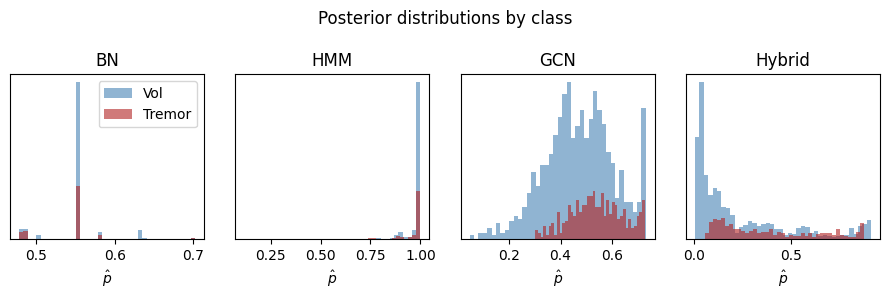

In [36]:
plt.figure(figsize=(9,3))
for i,(name,p) in enumerate({'BN':p_bn, 'HMM': p_hmm,'GCN':p_gcn_test, 'Hybrid':p_hyb}.items()):
    plt.subplot(1,4,i+1)
    plt.hist(p[y_true==0], bins=40, alpha=.6, label='Vol', color='steelblue')
    plt.hist(p[y_true==1], bins=40, alpha=.6, label='Tremor', color='firebrick')
    plt.title(name); plt.xlabel(r'$\hat p$'); plt.yticks([])
    if i==0: plt.legend()
plt.suptitle("Posterior distributions by class")
plt.tight_layout(); plt.show()
